<a href="https://colab.research.google.com/github/young-hyun-park/training/blob/master/u_net_encoder_clf_ipyb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torch.nn.functional as F
import albumentations.pytorch
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import cv2

In [2]:
seed = 1

lr = 0.001
momentum = 0.99

batch_size = 32
test_batch_size = 3

epochs = 200
log_interval = 100

In [3]:
path = '/content/drive/MyDrive/oxford_pet'
image_path =os.path.join(path+'/images')

In [4]:
image_path_list = glob(image_path+'/*.jpg')

In [5]:
label_list = list()
for path in image_path_list:
    label_list.append(re.sub('_\d+','',path).split('/')[-1].split('.')[0])

In [6]:
class_list = set()
for path in image_path_list:
  file_name = os.path.splitext(path)[0]
  class_name = re.sub('_\d+','',file_name).split('/')[-1]
  class_list.add(class_name)
class_list = sorted(list(class_list))

class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [7]:
df= pd.DataFrame(list(zip(image_path_list,label_list)),index = range(len(image_path_list)),columns = ['image_path','label'])

In [8]:
binary_idx = list()
for i in range(7387):
  label_idx = class2idx[df.iloc[i,1]]
  if label_idx <12:
    binary_idx.append('0')
  else:
    binary_idx.append('1')

In [9]:
len(binary_idx)

7387

In [10]:
df['Binary'] = binary_idx

In [11]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size = 0.20, random_state = 42,stratify = df['Binary'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [12]:
train_df

,image_path,label,Binary
0,/content/drive/MyDrive/oxford_pet/images/ameri...,american_bulldog,1
1,/content/drive/MyDrive/oxford_pet/images/germa...,german_shorthaired,1
2,/content/drive/MyDrive/oxford_pet/images/Abyss...,Abyssinian,0
3,/content/drive/MyDrive/oxford_pet/images/Persi...,Persian,0
4,/content/drive/MyDrive/oxford_pet/images/ameri...,american_bulldog,1
...,...,...,...
5904,/content/drive/MyDrive/oxford_pet/images/chihu...,chihuahua,1
5905,/content/drive/MyDrive/oxford_pet/images/Bomba...,Bombay,0
5906,/content/drive/MyDrive/oxford_pet/images/engli...,english_cocker_spaniel,1
5907,/content/drive/MyDrive/oxford_pet/images/staff...,staffordshire_bull_terrier,1


In [13]:
class Dataset(Dataset):
    def __init__(self, data_path,labels,transform = None):
        self.data_path = data_path
        self.transform = transform
        self.labels = labels
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        image = Image.open(path).convert('RGB')
        image = image.resize((256,256))
        image = np.array(image)
        image = image/255.0

        label = self.labels[idx]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed['image']
        image = image.transpose(2,0,1)
        image = torch.as_tensor(image.copy())
        sample = {'image':image, 'label' : label}
        return sample
        

In [14]:
train_transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.OneOf([A.ShiftScaleRotate(shift_limit = 0.1,rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
             # affine 변환
             A.IAAAffine(shear=15, p=0.5, mode= 'constant')],p = 0.8),     
     A.RandomBrightnessContrast(p = 0.8),
     ]
    )

In [15]:
train_image_path = train_df['image_path'].values
train_label = train_df['Binary'].astype('uint8').values
test_image_path = test_df['image_path'].values
test_label = test_df['Binary'].astype('uint8').values

In [16]:
train_data = Dataset(train_image_path,train_label,transform = train_transform)
test_data = Dataset(test_image_path,test_label)

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False,
)

In [18]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [19]:
class MLP(nn.Module):
  def __init__(self,in_channel,out_channel):
    super(MLP,self).__init__()
    self.linear = nn.Linear(in_channel,out_channel,bias = True)
    self.batchnorm = nn.BatchNorm1d(out_channel)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    layer = self.linear(x)
    layer = self.batchnorm(layer)
    layer = self.relu(layer)
    return layer

In [20]:
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear = False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.flatten = nn.Flatten()
        self.mlp1 = MLP(262144,128)
        self.mlp2 = MLP(128,64)
        self.out = MLP(64,n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = nn.Dropout(0.3)(x2)
        x3 = self.down2(x2)
        x3 = nn.Dropout(0.3)(x3)        
        x4 = self.down3(x3)
        x4 = nn.Dropout(0.3)(x4)        
        x5 = self.down4(x4)
        x5 = nn.Dropout(0.3)(x5)
        flat = self.flatten(x5)
        layer = nn.Dropout(0.5)(flat)
        layer = self.mlp1(layer)
        layer = nn.Dropout(0.5)(layer)
        layer = self.mlp2(layer)
        layer = nn.Dropout(0.5)(layer)
        layer = self.out(layer)
        return layer

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(3,2).to(device)

In [22]:
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5,weight_decay=0.001)
train_loss= list()
train_acc = list()
loss_val = list()
val_acc = list()
PATH = '/content/drive/MyDrive/oxford_pet/check_points'

In [25]:
import time
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
 
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4,weight_decay=1e-4)
train_loss= list()
train_acc = list()
loss_val = list()
val_acc = list()
PATH = '/content/drive/MyDrive/oxford_pet/check_points'
for epoch in range(1, epochs + 1):
    # Train Mode
    net.train()
    start  = time.time()
    correct = 0
    cost = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data['image'].to(device= device, dtype = torch.float32)
        labels = torch.as_tensor(np.array(data['label'])).to(device= device, dtype = torch.long)
        optimizer.zero_grad()
        output = net(inputs)
        loss = criterion(output, labels)   # https://pytorch.org/docs/stable/nn.html#nll-loss
        loss.backward()
        optimizer.step()
        cost += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
    torch.save({
          'model': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'epoch' : epoch
          }, PATH+'U-Net_binary_clf_epoch{}_checkpoint'.format(epoch))

    print('Train Epoch: {},Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), time :{:.0f}'.format(
                epoch, cost/len(train_loader),correct,len(train_loader.dataset),
                100 * correct / len(train_loader.dataset),time.time()-start))
    train_loss.append(cost/len(train_loader))
    train_acc.append(100 * correct / len(train_loader.dataset))
    # Test mode
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            test_inputs = data['image'].to(device = device, dtype = torch.float32)
            test_labels = torch.as_tensor(np.array(data['label'])).to(device= device, dtype = torch.long)
            test_output = net(test_inputs)
            test_loss += criterion(test_output, test_labels).item() # sum up batch loss
            pred = test_output.argmax(dim=1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(test_labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    loss_val.append(test_loss)
    val_acc.append(100 * correct / len(test_loader.dataset))
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))

Train Epoch: 1,Loss: 0.6923, Accuracy: 2851/5909 (48.25%), time :133
Test set: Average loss: 0.6707, Accuracy: 763/1478 (51.62%)

Train Epoch: 2,Loss: 0.6631, Accuracy: 3092/5909 (52.33%), time :133
Test set: Average loss: 0.6642, Accuracy: 800/1478 (54.13%)

Train Epoch: 3,Loss: 0.6493, Accuracy: 3326/5909 (56.29%), time :134
Test set: Average loss: 0.6432, Accuracy: 847/1478 (57.31%)

Train Epoch: 4,Loss: 0.6209, Accuracy: 3572/5909 (60.45%), time :134
Test set: Average loss: 0.5916, Accuracy: 950/1478 (64.28%)

Train Epoch: 5,Loss: 0.6159, Accuracy: 3679/5909 (62.26%), time :133
Test set: Average loss: 0.6002, Accuracy: 984/1478 (66.58%)

Train Epoch: 6,Loss: 0.5988, Accuracy: 3802/5909 (64.34%), time :134
Test set: Average loss: 0.5736, Accuracy: 1042/1478 (70.50%)

Train Epoch: 7,Loss: 0.5804, Accuracy: 4011/5909 (67.88%), time :134
Test set: Average loss: 0.5528, Accuracy: 1016/1478 (68.74%)

Train Epoch: 8,Loss: 0.5672, Accuracy: 4174/5909 (70.64%), time :133
Test set: Average l

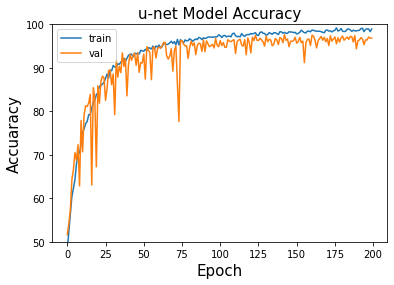

In [32]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('u-net Model Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuaracy', fontsize = 15)
plt.ylim(50,100) 
plt.legend(['train','val'], loc='upper left')
plt.show()

In [31]:
len(train_acc)

200

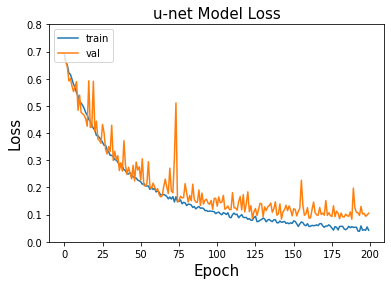

In [33]:
plt.plot(train_loss)
plt.plot(loss_val)
plt.title('u-net Model Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,0.8)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [38]:
path = '/content/drive/MyDrive/oxford_pet/u-net_binary_clf_model'

In [ ]:
pred = F.softmax(masks_pred,dim = 1)
prediction = torch.argmax(pred,dim = 1)
prediction[0]

In [40]:
torch.save({
          'model': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'epoch' : epoch}
          ,path)

In [ ]:
plt.imshow(inputs[1].permute(1,2,0).cpu().data.numpy())
plt.show()

In [ ]:
inputs.shape

In [ ]:
plt.imshow(masks[1].cpu().data.numpy())
plt.show()

In [ ]:
plt.imshow(prediction[1].cpu().data.numpy())
plt.show()

In [ ]:
mIoU(masks_pred[0],labels[0])